In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle

# from statsmodels.tsa.seasonal import MSTL
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_pinball_loss, mean_squared_error, mean_absolute_error

import data_prepro as data_prepro

In [2]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'c:\\Users\\ytl_c\\OneDrive\\Desktop\\22 ECON Hiwi\\2023_11-Karlsruhe-Bicycle-Data\\data_prepro.py'>

### Data Import

In [3]:
# import csv file
df = pd.read_csv('./data/2012-04-25_2024-01-25_KA_bike_weather.csv')

# change date col to datetime
df['date'] = pd.to_datetime(df['date'])
# set index as timestamp_CET but keep col
df.set_index('date', inplace=True, drop=False)
# rename date to timestamp_CET
df.rename(columns={'date': 'timestamp_CET'}, inplace=True)

print(df.info())
print(df.columns)
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4291 entries, 2012-04-25 to 2024-01-25
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp_CET   4291 non-null   datetime64[ns]
 1   bike_count      4291 non-null   float64       
 2   temperature     4291 non-null   float64       
 3   humidity        4291 non-null   float64       
 4   windspeed       4291 non-null   float64       
 5   wind_direction  4291 non-null   float64       
 6   visibility      4291 non-null   float64       
 7   precipitation   4291 non-null   float64       
 8   sun             4291 non-null   int64         
 9   windspeed_max   4291 non-null   float64       
 10  precip_indic    4291 non-null   float64       
 11  precip_type     4291 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 435.8 KB
None
Index(['timestamp_CET', 'bike_count', 'temperature', 'humidity', 'wind

,timestamp_CET,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
date,,,,,,,,,,,,
2024-01-21,2024-01-21,994.0,-1.500000,87.666667,1.587500,187.500000,14942.500000,0.0,191,7.7,0.0,0.0
2024-01-22,2024-01-22,3398.0,7.479167,76.791667,7.075000,223.750000,47245.416667,5.4,0,18.0,1.0,6.0
2024-01-23,2024-01-23,4427.0,8.358333,74.541667,7.250000,231.250000,38257.916667,0.5,164,16.6,0.5,3.0
2024-01-24,2024-01-24,4124.0,11.945833,72.291667,8.350000,234.583333,45765.833333,1.9,7,18.8,0.0,0.0
2024-01-25,2024-01-25,4594.0,9.366667,85.083333,3.345833,229.583333,23374.583333,1.0,220,7.5,0.0,0.0


### Random Forest & Feature Importance

In [52]:
train_size = 0.99
test_size = 1 - train_size

df_train = df.iloc[:int(len(df)*train_size)]
df_test = df.iloc[int(len(df)*train_size):]

# = = = = = = = = = = = = = = =
# TRAIN DATA
df_dummy = data_prepro.create_dummy_df(df_train, holiday_method='separate', school_holidays_bw=True)
X_train_dummy = df_dummy.drop(columns=['bike_count', 'timestamp_CET'])
y_train = df_dummy['bike_count']

df_features = data_prepro.create_features_df(df_train, holiday_method='separate', school_holidays_bw=True)
X_train_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET'])
y_train_fturs = df_features['bike_count']

# = = = = = = = = = = = = = = =
# TEST DATA
X_test_dummy = data_prepro.create_dummy_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])
X_test_fturs = data_prepro.create_features_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])

y_test = df_test['bike_count']

In [53]:
model = RandomForestRegressor(max_depth=20, n_estimators=150)
# fit model
model.fit(X_train_dummy, y_train)

RandomForestRegressor(max_depth=20, n_estimators=150)

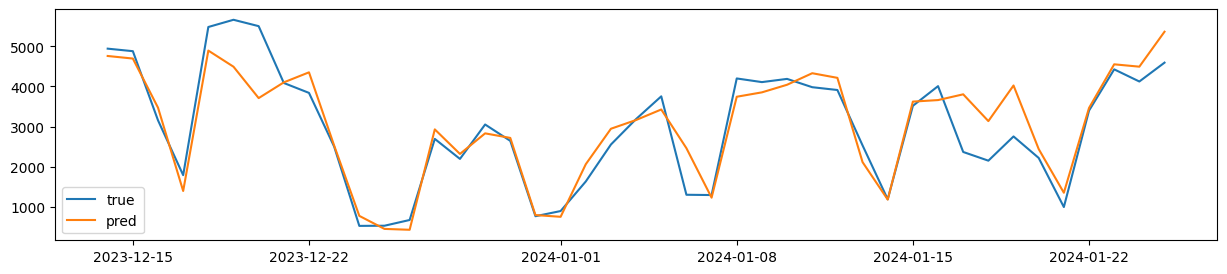

RMSE:  570.3998618906661
MAE:  394.8011339773694


In [54]:
# predict on test set
y_pred_insample = model.predict(X_train_dummy)

# predict on test set
X_test = df[int(len(df)*train_size):].drop('bike_count', axis=1)
y_test = df['bike_count'][int(len(df)*train_size):]
y_pred = model.predict(X_test_dummy)

# plot predictions
plt.figure(figsize=(15, 3))
plt.plot(y_test, label='true')
plt.plot(y_test.index, y_pred, label='pred')
plt.legend()
plt.show()

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

#### Feature Importance

Elapsed time to compute the importances: 0.069 seconds


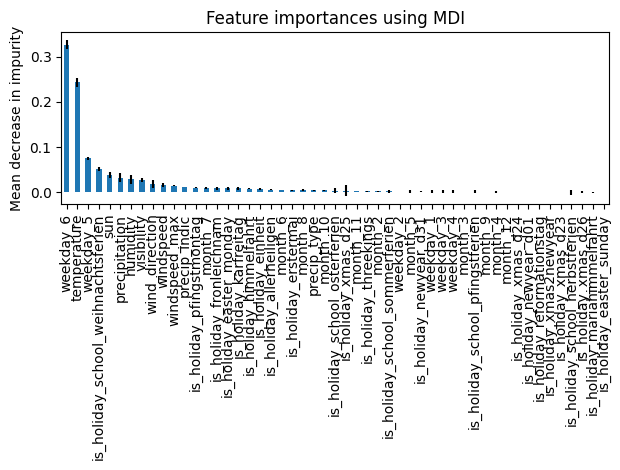

In [56]:
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=X_train_dummy.columns)
# sort large to small
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### No Weather, No Holiday

In [20]:
df_no_weather = df[['timestamp_CET', 'bike_count']].copy()
df_no_weather_dummy = data_prepro.create_dummy_df(df_no_weather, holiday_method='None', school_holidays_bw=False)
df_no_weather_dummy.head()

,timestamp_CET,bike_count,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,
2012-04-25,2012-04-25,4593.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2012-04-26,2012-04-26,5849.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2012-04-27,2012-04-27,5846.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2012-04-28,2012-04-28,4261.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2012-04-29,2012-04-29,1901.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
train_size = 0.99
test_size = 1 - train_size

n_train = int(len(df_no_weather_dummy)*train_size)

df_train = df_no_weather_dummy.iloc[:n_train]
df_test = df_no_weather_dummy.iloc[n_train:]

# = = = = = = = = = = = = = = =
# TRAIN DATA
X_train_dummy = df_train.drop(columns=['bike_count', 'timestamp_CET'])
y_train = df_train['bike_count']
# = = = = = = = = = = = = = = =
# TEST DATA
X_test_dummy = df_test.drop(columns=['bike_count', 'timestamp_CET'])
y_test = df_test['bike_count']

In [24]:
model = RandomForestRegressor(max_depth=20, n_estimators=150)
# fit model
model.fit(X_train_dummy, y_train)

RandomForestRegressor(max_depth=20, n_estimators=150)

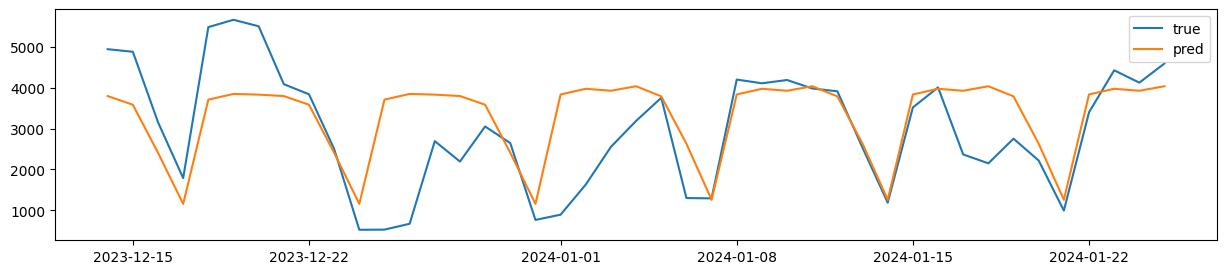

RMSE:  1231.7203990740109
MAE:  878.6066143450541


In [26]:
# predict on test set
y_pred_insample = model.predict(X_train_dummy)

# predict on test set
X_test = df[int(len(df)*train_size):].drop('bike_count', axis=1)
y_test = df['bike_count'][int(len(df)*train_size):]
y_pred = model.predict(X_test_dummy)

# plot predictions
plt.figure(figsize=(15, 3))
plt.plot(y_test, label='true')
plt.plot(y_test.index, y_pred, label='pred')
plt.legend()
plt.show()

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

Elapsed time to compute the importances: 0.044 seconds


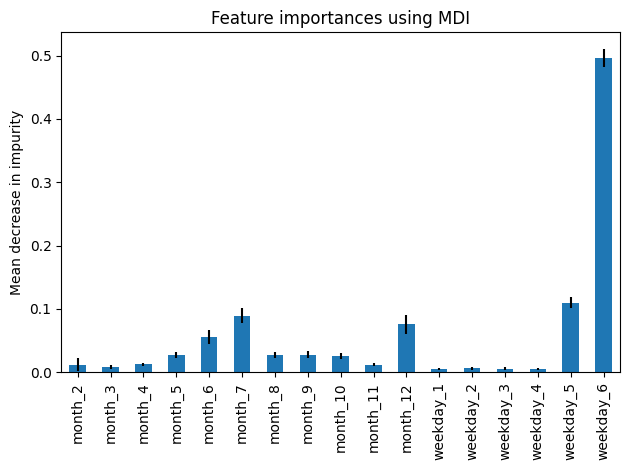

In [25]:
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=X_train_dummy.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Quantile Regression Forest

In [27]:
from sklearn_quantile import RandomForestQuantileRegressor

In [31]:
train_size = 0.99
test_size = 1 - train_size

n_train = int(len(df_no_weather_dummy)*train_size)

df_train = df_no_weather_dummy.iloc[:n_train]
df_test = df_no_weather_dummy.iloc[n_train:]

# = = = = = = = = = = = = = = =
# TRAIN DATA
X_train_dummy = df_train.drop(columns=['bike_count', 'timestamp_CET'])
y_train = df_train['bike_count']
# = = = = = = = = = = = = = = =
# TEST DATA
X_test_dummy = df_test.drop(columns=['bike_count', 'timestamp_CET'])
y_test = df_test['bike_count']

In [34]:
qrf = RandomForestQuantileRegressor(q=[0.05, 0.50, 0.95])
qrf.fit(X_train_dummy, y_train)

RandomForestQuantileRegressor(q=[0.05, 0.5, 0.95])

In [38]:
y_pred_5, y_pred_median, y_pred_95 = qrf.predict(X_test_dummy)

c:\Users\ytl_c\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ytl_c\miniconda3\Lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


C:\Users\ytl_c\AppData\Local\Temp\ipykernel_21800\3149757959.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xx, y_med, 'r-', label='Predicted median', color="orange")


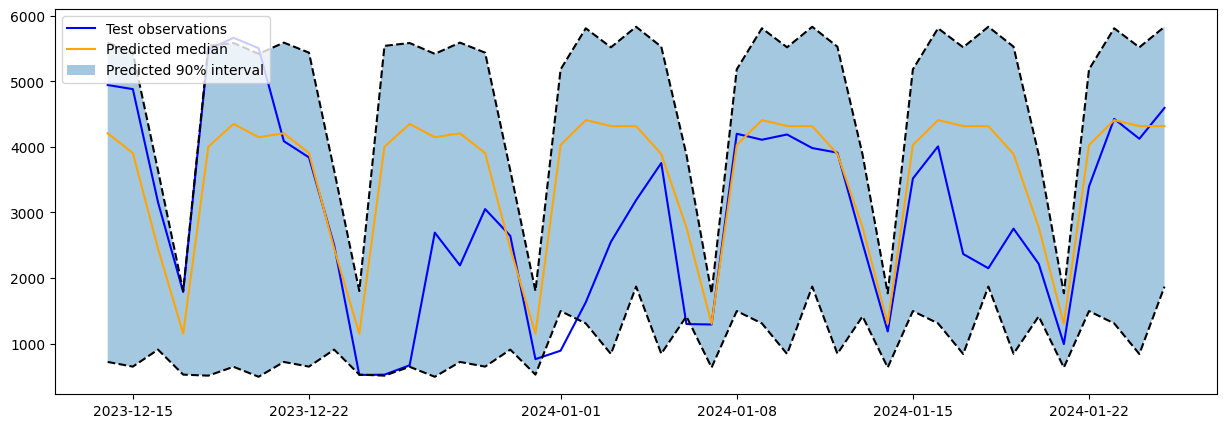

In [45]:
y_lower = y_pred_5
y_med = y_pred_median
y_upper = y_pred_95

xx = y_test.index

fig = plt.figure(figsize=(15, 5))
plt.plot(xx, y_test, 'b', label='Test observations')
plt.plot(xx, y_med, 'r-', label='Predicted median', color="orange")
plt.plot(xx, y_upper, 'k--')
plt.plot(xx, y_lower, 'k--')
plt.fill_between(xx, y_lower, y_upper, alpha=0.4, label='Predicted 90% interval')
plt.legend(loc='upper left')
plt.show()

# qrf.score(X_test_dummy, y_test) # mean pinball loss

In [50]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer
# from pprint import pprint

# param_grid = dict(
#     n_estimators=[100, 150, 200, 250, 300],
#     max_depth=[2, 5, 10, 15, 20],
#     min_samples_leaf=[1, 5, 10, 20, 30, 50],
#     min_samples_split=[2, 5, 10, 20, 30, 50],
# )

# q = 0.05
# neg_mean_pinball_loss_05p_scorer = make_scorer(
#     mean_pinball_loss,
#     alpha=q,
#     greater_is_better=False,  # maximize the negative loss
# )

# qrf = RandomForestQuantileRegressor(random_state=0, q=q)
# search_05p = RandomizedSearchCV(
#     qrf,
#     param_grid,
#     n_iter=5,  # increase this if computational budget allows
#     scoring=neg_mean_pinball_loss_05p_scorer,
#     n_jobs=1,
#     random_state=0, 
#     verbose=4
# ).fit(X_train_dummy, y_train)
# pprint(search_05p.best_params_)

# {'max_depth': 20,
#  'min_samples_leaf': 20,
#  'min_samples_split': 50,
#  'n_estimators': 100}

In [51]:
# from sklearn.base import clone

# q = 0.95
# neg_mean_pinball_loss_95p_scorer = make_scorer(
#     mean_pinball_loss,
#     alpha=q,
#     greater_is_better=False,  # maximize the negative loss
# )
# search_95p = clone(search_05p).set_params(
#     estimator__q=q,
#     scoring=neg_mean_pinball_loss_95p_scorer,
# )
# search_95p.fit(X_train_dummy, y_train)
# pprint(search_95p.best_params_)

# {'max_depth': 15,
#  'min_samples_leaf': 10,
#  'min_samples_split': 50,
#  'n_estimators': 300}